In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import logging
from tqdm.auto import tqdm

# ML libraries
import torch.nn as nn # Added for loss function
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Check if in Colab environment for drive mount
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

In [ ]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logger.info(f"Using device: {device}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
    try:
        total_mem = torch.cuda.get_device_properties(0).total_memory
        logger.info(f"Total GPU Memory: {total_mem / 1e9:.2f} GB")
    except Exception as e:
        logger.warning(f"Could not get GPU memory info: {e}")

In [ ]:
# Mount Google Drive (only if in Colab)
def mount_drive():
    """Mount Google Drive to access data if running in Google Colab."""
    if IN_COLAB:
        logger.info("Running in Colab. Mounting Google Drive...")
        drive.mount('/content/drive')
        logger.info("Google Drive mounted successfully.")
    else:
        logger.info("Not running in Colab. Skipping Google Drive mount.")

# Read a single file with error handling
def read_file(file_path: str) -> Optional[str]:
    """Read a file with encoding error handling."""
    if not os.path.exists(file_path):
        logger.warning(f"File not found: {file_path}")
        return None
    try:
        # Try UTF-8 first
        with open(file_path, 'r', encoding='utf-8') as f:
            return f.read()
    except UnicodeDecodeError:
        logger.warning(f"UTF-8 decoding failed for {file_path}. Trying Latin-1.")
        try:
            # Fall back to Latin-1
            with open(file_path, 'r', encoding='latin-1') as f:
                return f.read()
        except Exception as e:
            logger.error(f"Failed to read file {file_path} even with Latin-1: {str(e)}")
            return None
    except Exception as e:
        logger.error(f"Failed to read file {file_path}: {str(e)}")
        return None

# Load classification data and preprocess
def load_and_preprocess_data(csv_path: str, base_dir: str) -> pd.DataFrame:
    """Load classification data, extract info, and check file readability."""
    logger.info(f"Loading classification data from {csv_path}")
    df = pd.read_csv(csv_path)

    # Verify required columns
    required_columns = ['Index', 'Label']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in the CSV file")

    logger.info("Extracting filenames and years from Index column...")
    # Use str.split with error handling for potentially malformed Index entries
    df[['Year', 'Filename']] = df['Index'].str.split('_', n=1, expand=True)

    # Check for rows where splitting might have failed (e.g., no '_')
    if df['Filename'].isnull().any():
        logger.warning(f"Found {df['Filename'].isnull().sum()} rows with potentially malformed 'Index' (missing '_').")
        # Decide how to handle: drop, fill, or raise error. Here, we'll log and potentially drop later.

    # --- Pre-filter based on file existence and readability ---
    logger.info("Checking file existence and readability...")
    readable_indices = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Checking files"):
        if pd.isna(row['Year']) or pd.isna(row['Filename']):
            logger.warning(f"Skipping row {idx} due to missing Year/Filename derived from Index '{row['Index']}'")
            continue
        file_path = os.path.join(base_dir, str(row['Year']), str(row['Filename']))
        # Only check for existence here, read attempt will happen in Dataset
        if os.path.exists(file_path):
             readable_indices.append(idx)
        else:
             logger.warning(f"File not found for Index {row['Index']} at expected path: {file_path}")

    original_count = len(df)
    df_filtered = df.loc[readable_indices].copy() # Use .copy() to avoid SettingWithCopyWarning
    filtered_count = len(df_filtered)
    logger.info(f"Filtered out {original_count - filtered_count} samples due to missing files.")

    if filtered_count == 0:
        raise ValueError("No readable files found based on the provided CSV and base directory.")

    logger.info(f"Loaded {filtered_count} valid records.")
    logger.info(f"Class distribution: {df_filtered['Label'].value_counts().to_dict()}")
    return df_filtered


# Create dataset class for on-the-fly loading
class MICDataset(Dataset):
    """PyTorch dataset for MIC classification with on-the-fly file loading."""

    def __init__(self, dataframe: pd.DataFrame, base_dir: str, tokenizer, max_length: int = 512):
        self.dataframe = dataframe.reset_index(drop=True) # Ensure contiguous index
        self.base_dir = base_dir
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Simple cache (consider LRU cache for more complex scenarios)
        self.cache = {}
        self.cache_hits = 0
        self.cache_misses = 0

        logger.info(f"Created dataset with {len(self.dataframe)} samples")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Check cache first
        if idx in self.cache:
            self.cache_hits += 1
            return self.cache[idx]

        self.cache_misses += 1
        # Get file info from pre-filtered dataframe
        row = self.dataframe.iloc[idx]
        year = str(row['Year'])
        filename = str(row['Filename'])
        file_path = os.path.join(self.base_dir, year, filename)
        label = row['Label']

        # Read file (already checked for existence, but check readability)
        text = read_file(file_path)

        # Handle read failures (should be less common now)
        if text is None:
            logger.error(f"Failed to read file {file_path} during __getitem__ for index {idx}. Using placeholder.")
            # This should ideally not happen if pre-filtering worked.
            # If it does, it indicates an issue during the read itself (e.g., permissions, decoding)
            text = "[READ_ERROR]" # Use a distinct placeholder

        # Tokenize
        try:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_length,
                return_tensors='pt'
            )
        except Exception as e:
             logger.error(f"Tokenization failed for index {idx}, file {file_path}: {e}")
             # Handle tokenization error, e.g., return dummy data or raise exception
             # Returning dummy data might be problematic. Consider raising error or filtering.
             # For now, create dummy encoding to avoid crashing dataloader
             logger.warning("Returning dummy encoding due to tokenization error.")
             input_ids = torch.zeros(self.max_length, dtype=torch.long)
             attention_mask = torch.zeros(self.max_length, dtype=torch.long)
             encoding = {'input_ids': input_ids.unsqueeze(0), 'attention_mask': attention_mask.unsqueeze(0)}


        # Remove batch dimension
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        encoding['labels'] = torch.tensor(label, dtype=torch.long)

        # Cache the result (more aggressively, maybe cache all if memory allows)
        # Simple strategy: cache every Nth item to balance memory and speed
        if idx % 5 == 0: # Cache 20% of items, adjust as needed
            self.cache[idx] = encoding

        return encoding

    def log_cache_stats(self):
        total_accesses = self.cache_hits + self.cache_misses
        if total_accesses > 0:
            hit_rate = (self.cache_hits / total_accesses) * 100
            logger.info(f"Cache Stats: Hits={self.cache_hits}, Misses={self.cache_misses}, Hit Rate={hit_rate:.2f}%")
        else:
            logger.info("Cache Stats: No accesses recorded.")


# Split data into train and validation sets using stratified sampling
def split_data(df: pd.DataFrame, val_ratio: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Split data with stratification to preserve class distribution."""
    logger.info(f"Splitting data with validation ratio {val_ratio}")

    # Ensure 'Label' column exists and is suitable for stratification
    if 'Label' not in df.columns:
        raise ValueError("Column 'Label' required for stratification is missing.")
    if df['Label'].nunique() < 2:
         logger.warning("Only one class present in the dataset. Stratification may not be meaningful.")
         # Handle as needed, maybe raise error or proceed without stratification


    train_df, val_df = train_test_split(
        df,
        test_size=val_ratio,
        random_state=42,
        stratify=df['Label'] if df['Label'].nunique() >= 2 else None # Stratify only if multiple classes
    )

    logger.info(f"Training set: {len(train_df)} samples, Class distribution: {train_df['Label'].value_counts().to_dict()}")
    logger.info(f"Validation set: {len(val_df)} samples, Class distribution: {val_df['Label'].value_counts().to_dict()}")

    return train_df, val_df

# Calculate class weights for imbalanced dataset
def calculate_class_weights(labels: List[int], device: torch.device) -> torch.Tensor:
    """Calculate weights to handle class imbalance and move to target device."""
    unique_labels = np.unique(labels)
    logger.info(f"Calculating class weights for labels: {unique_labels}")
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_labels,
        y=labels
    )
    logger.info(f"Computed class weights (CPU): {class_weights}")
    # Move weights to the target device (e.g., 'cuda' or 'cpu')
    return torch.tensor(class_weights, dtype=torch.float).to(device)

# Define metrics computation function
def compute_metrics(pred):
    """Calculate evaluation metrics."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=0) # Handle zero division
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Plot training history
def plot_training_history(trainer: Trainer, output_dir: str):
    """Visualize training and validation loss."""
    logger.info("Plotting training history...")
    history = trainer.state.log_history

    train_logs = [log for log in history if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in history if 'eval_loss' in log]

    if not train_logs and not eval_logs:
        logger.warning("No training or evaluation logs found. Cannot plot history.")
        return

    plt.figure(figsize=(12, 7))

    if train_logs:
        train_steps = [log['step'] for log in train_logs]
        train_losses = [log['loss'] for log in train_logs]
        plt.plot(train_steps, train_losses, label='Training Loss', marker='.', linestyle='-', color='royalblue')

    if eval_logs:
        eval_steps = [log['step'] for log in eval_logs]
        eval_losses = [log['eval_loss'] for log in eval_logs]
        plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='o', linestyle='--', color='orangered')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Steps')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plot_path = os.path.join(output_dir, 'training_history.png')
    plt.savefig(plot_path)
    logger.info(f"Training history plot saved to {plot_path}")
    plt.show()


# Plot confusion matrix
def plot_confusion_matrix_func(trainer: Trainer, dataset: Dataset, output_dir: str, class_names: List[str]):
    """Generate, visualize, and print confusion matrix and classification report."""
    logger.info("Generating predictions for confusion matrix...")
    predictions = trainer.predict(dataset)

    preds = predictions.predictions.argmax(-1)
    labels = predictions.label_ids

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    cm_plot_path = os.path.join(output_dir, 'confusion_matrix.png')
    plt.savefig(cm_plot_path)
    logger.info(f"Confusion matrix plot saved to {cm_plot_path}")
    plt.show()

    # Print classification report
    logger.info("\nClassification Report:")
    report = classification_report(labels, preds, target_names=class_names, zero_division=0)
    print(report)
    # Save report to file
    report_path = os.path.join(output_dir, 'classification_report.txt')
    with open(report_path, 'w') as f:
        f.write(report)
    logger.info(f"Classification report saved to {report_path}")

# --- Custom Trainer for Weighted Loss ---
class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        if self.class_weights is not None:
             # Ensure weights are initially on the correct device
             expected_device = self.args.device # Get device from TrainingArguments
             if self.class_weights.device != expected_device:
                 self.class_weights = self.class_weights.to(expected_device)
             logger.info(f"WeightedLossTrainer initialized with class weights on device: {self.class_weights.device}")


    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        How the loss is computed by Trainer. By overriding this method, we can incorporate class weights.
        Uses **kwargs to accept any extra arguments passed by Trainer's internal methods.
        """

        labels = inputs.pop("labels")
        # Pass remaining inputs to the model
        outputs = model(**inputs)
        logits = outputs.get("logits") # Use .get() for safer access

        if logits is None:
             raise ValueError("Model did not return logits")

        # Compute custom loss using class weights
        if self.class_weights is not None:
            # Ensure weights are on the same device as logits (important!)
            if self.class_weights.device != logits.device:
                self.class_weights = self.class_weights.to(logits.device)
                # Log this change as it might indicate an unexpected device mismatch earlier
                logger.warning(f"Moved class_weights to device {logits.device} within compute_loss")

            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            # Default CrossEntropyLoss if no weights provided
             loss_fct = nn.CrossEntropyLoss()
             loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [ ]:
mount_drive()

Mounted at /content/drive


Checking files:   0%|          | 0/2081 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.559100,0.456531,0.839329,0.652850,0.707865,0.605769
2,0.407600,0.541549,0.851319,0.690000,0.718750,0.663462
3,0.276500,0.374084,0.848921,0.742857,0.645390,0.875000


***** train metrics *****
  epoch                    =        3.0
  total_flos               =  1223245GF
  train_loss               =     0.5813
  train_runtime            = 0:02:59.30
  train_samples_per_second =     27.841
  train_steps_per_second   =       1.74


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.8489
  eval_f1                 =     0.7429
  eval_loss               =     0.3741
  eval_precision          =     0.6454
  eval_recall             =      0.875
  eval_runtime            = 0:00:03.96
  eval_samples_per_second =    105.217
  eval_steps_per_second   =      6.813


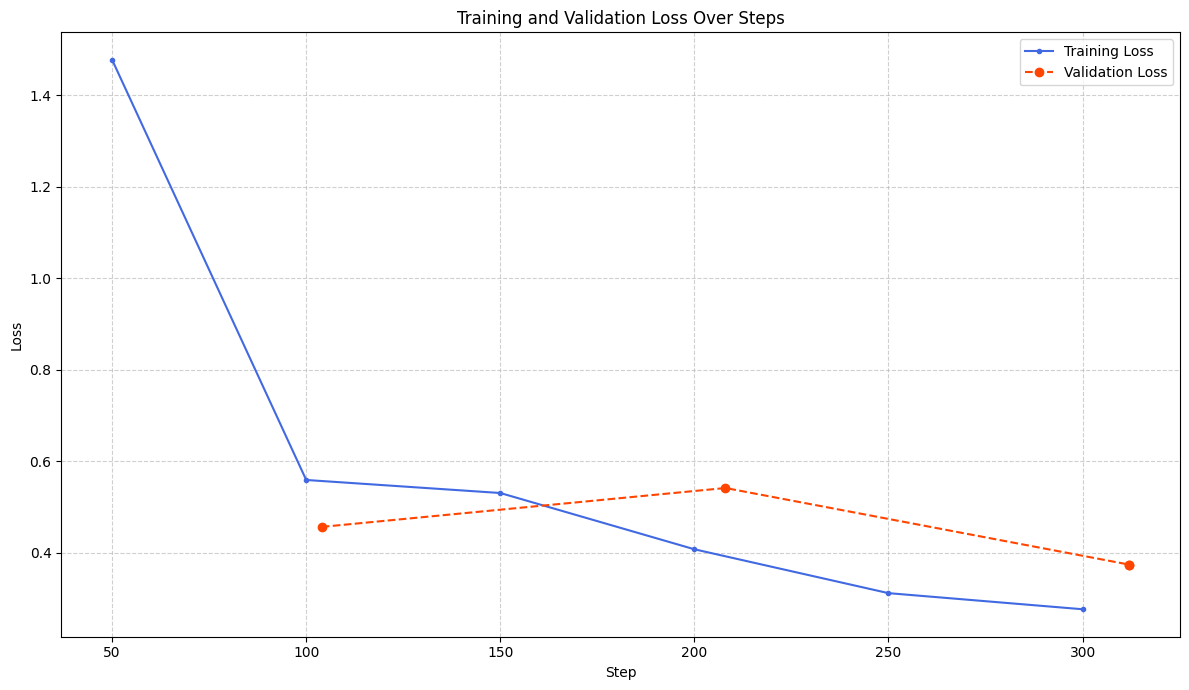

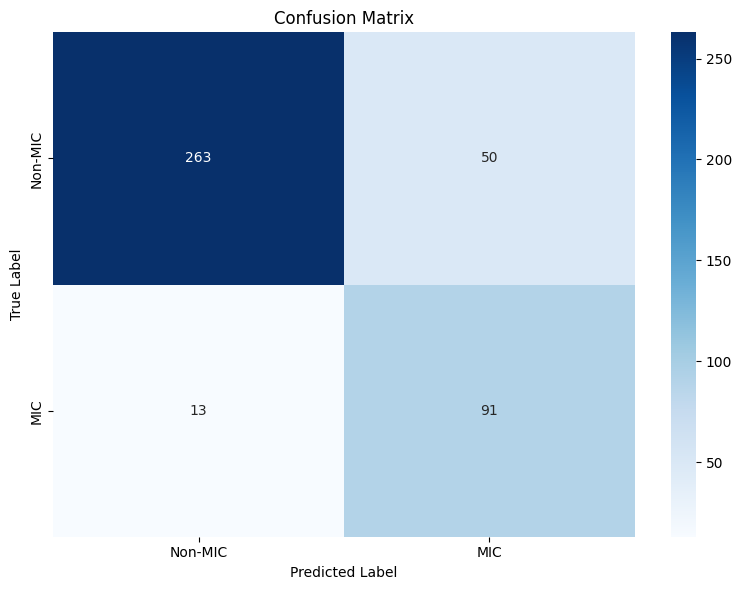

              precision    recall  f1-score   support

     Non-MIC       0.95      0.84      0.89       313
         MIC       0.65      0.88      0.74       104

    accuracy                           0.85       417
   macro avg       0.80      0.86      0.82       417
weighted avg       0.88      0.85      0.86       417



In [8]:
# Set paths (adjust if not using Colab/Drive)
if IN_COLAB:
    base_drive_path = '/content/drive/MyDrive/GSOC'
else:
    # Define base path if running locally
    base_drive_path = './GSOC'
    os.makedirs(base_drive_path, exist_ok=True) # Ensure local dirs exist

data_dir = os.path.join(base_drive_path, 'processed_files')
csv_path = os.path.join(base_drive_path, 'classified_files/2008_classification.csv')
output_dir = os.path.join(base_drive_path, 'mic_model_output')
model_variant = "eventdata-utd/conflibert-binary-classification"

# Create output directory
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, 'logs'), exist_ok=True) # Ensure logs dir exists

# Load classification data, preprocess, and pre-filter unreadable files
try:
    df = load_and_preprocess_data(csv_path, data_dir)
except ValueError as e:
    logger.error(f"Failed to load or preprocess data: {e}")
    exit(1) # Exit if no data could be loaded


# Split data into train and validation sets
train_df, val_df = split_data(df, val_ratio=0.2)

# Initialize tokenizer
logger.info(f"Loading ConfliBERT tokenizer from {model_variant}...")
tokenizer = AutoTokenizer.from_pretrained(model_variant)

# Create datasets with on-the-fly loading
train_dataset = MICDataset(
    dataframe=train_df,
    base_dir=data_dir,
    tokenizer=tokenizer,
    max_length=512
)

val_dataset = MICDataset(
    dataframe=val_df,
    base_dir=data_dir,
    tokenizer=tokenizer,
    max_length=512
)

# Calculate class weights for imbalance handling and move to GPU device
class_weights = calculate_class_weights(train_df['Label'].tolist(), device)

# Initialize model and move to GPU
logger.info(f"Loading ConfliBERT model from {model_variant}...")
model = AutoModelForSequenceClassification.from_pretrained(
    model_variant,
    num_labels=2  # Binary classification (0 and 1)
)

# Set up training arguments
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,
    warmup_steps=250,
    weight_decay=0.01,
    logging_dir=os.path.join(output_dir, 'logs'),
    logging_strategy="steps",
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
)

# Initialize custom Trainer with weighted loss
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    processing_class=tokenizer, # Pass tokenizer for auto-padding if needed by model later
    class_weights=class_weights
)

# Train the model
logger.info("Starting training...")
try:
    train_result = trainer.train()
    logger.info("Training finished.")

    # Log training metrics
    metrics = train_result.metrics
    trainer.log_metrics("train", metrics)
    trainer.save_metrics("train", metrics)
    trainer.save_state()

    # Save the final best model
    logger.info(f"Saving the best model to {output_dir}")
    trainer.save_model(output_dir)  # Saves the best model due to load_best_model_at_end=True
    # tokenizer is already saved via trainer.save_model if passed to constructor, but explicit save is also fine
    tokenizer.save_pretrained(output_dir)

    # Evaluate the *best* model on the validation set
    logger.info("Evaluating the best model on the validation set...")
    eval_results = trainer.evaluate(eval_dataset=val_dataset)
    logger.info(f"Evaluation results: {eval_results}")
    trainer.log_metrics("eval", eval_results)
    trainer.save_metrics("eval", eval_results)

    # Log dataset cache performance
    if hasattr(train_dataset, 'log_cache_stats'):
          train_dataset.log_cache_stats()
    if hasattr(val_dataset, 'log_cache_stats'):
          val_dataset.log_cache_stats()

    # Generate visualizations for the best model
    plot_training_history(trainer, output_dir)
    plot_confusion_matrix_func(trainer, val_dataset, output_dir, class_names=['Non-MIC', 'MIC'])

    logger.info("Training and evaluation completed successfully!")

except Exception as e:
    logger.error(f"An error occurred during training or evaluation: {e}", exc_info=True)